In [1]:
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportion_confint as ci
import os
%matplotlib inline

In [2]:
def process_line(line):
    tokens = line.split(" Total ")
    meat = tokens[1]
    tokens = meat.split(" Found ")
    total = int(tokens[0])
    if "frac" in tokens[1]:
        tokens = tokens[1].split(" frac ")
    elif "Frac" in tokens[1]:
        tokens = tokens[1].split(" Frac ")
    if tokens[0] == "":
        tokens[0] = "0"
    found = int(tokens[0])
    return total, found

In [3]:
def compute_stats(TP, FN, TN, FP):
    sensitivity = float(TP) / float(TP + FN)
    specificity = float(TN) / float(TN + FP)
    
    #statsmodels.stats.proportion.proportion_confint(count, nobs, alpha=0.05, method='normal')[source]
    
    ci_sen = ci(TP, TP + FN, alpha=0.05, method='beta')
    #ci_sen = [100.0 * ci_sen[0], 100.0 * ci_sen[1]]
    ci_spec = ci(TN, TN + FP, alpha=0.05, method='beta')
    #ci_spec = [100.0 * ci_spec[0], 100.0 * ci_spec[1]]
    #print(ci_sen, ci_spec)
    return sensitivity, specificity, ci_sen, ci_spec    

In [4]:
def get_all_cancer_types():
    cancer_types = []
    with open("../data/cancer-types.txt", "r") as reader:
        for line in reader:
            tokens = line.split("-")
            cancer_types.append(tokens[0])
    return cancer_types


In [5]:
def compute_total_sample_count(result_file):
    #print(result_file)
    reader = open(result_file, "r")
    lines = reader.readlines()
    
    # Tumor All
    T, F = process_line(lines[3])
    return T

In [6]:
def get_sample_count_all_cancers():
    cancer_types = get_all_cancer_types()
    sample_counts = {}
    for cancer in cancer_types:
        sample_counts[cancer] = compute_total_sample_count("../data/2hit/" + cancer + "-combinations.validate.out")
    return sample_counts

In [7]:
def compute_single_performance(result_file):
    #print(result_file)
    if "LAML-combinations" in result_file:
        return
    record = {}
    reader = open(result_file, "r")
    lines = reader.readlines()

    # Read date and do nothing
    # Test Tumor
    T, F = process_line(lines[1])
    test_TP = F
    test_FN = T - F
    record["test_tp"] = test_TP 
    record["test_fn"] = test_FN

    # Test Normal
    T, F = process_line(lines[2])
    test_TN = T - F
    test_FP = F
    record["test_tn"] = test_TN
    record["test_fp"] = test_FP
    
    test_sen, test_spec, test_ci_sen, test_ci_spec = compute_stats(test_TP, test_FN, test_TN, test_FP)
    record["test_sen"] = test_sen
    record["test_spec"] = test_spec
    record["test_ci_sen"] = test_ci_sen
    record["test_ci_spec"] = test_ci_spec

    # Tumor All
    T, F = process_line(lines[3])
    all_TP = F
    all_FN = T - F
    record["all_tp"] = all_TP
    record["all_fn"] = all_FN

    # Normal All
    T, F = process_line(lines[4])
    all_TN = T - F
    all_FP = F
    record["all_tn"] = all_TN
    record["all_fp"] = all_FP
    
    all_sen, all_spec, all_ci_sen, all_ci_spec = compute_stats(all_TP, all_FN, all_TN, all_FP)
    record["all_sen"] = all_sen
    record["all_spec"] = all_spec

    # Training Tumor
    T, F = process_line(lines[5])
    train_TP = F
    train_FN = T - F
    record["train_tp"] = train_TP
    record["train_fn"] = train_FN

    # Training Normal
    T, F = process_line(lines[6])
    train_TN = T - F
    train_FP = F
    record["train_tn"] = train_TN
    record["train_fp"] = train_FP
    
    train_sen, train_spec, train_ci_sen, train_ci_spec = compute_stats(train_TP, train_FN, train_TN, train_FP)
    #print(train_sen, train_spec, train_ci_sen, train_ci_spec)
    record["train_sen"] = train_sen
    record["train_spec"] = train_spec
    record["train_ci_sen"] = train_ci_sen
    record["train_ci_spec"] = train_ci_spec

    # F-measure

    # Test specificity, sensitivy and cis
    
    return record
    

In [8]:
def collect_all_performance(directory, cancer_types):
    records = {}
    for cancer in cancer_types:
        records[cancer] = compute_single_performance(directory + "/" + cancer + "-combinations.validate.out")
    return records
    

In [9]:
def compute_aggregate_performance(directory, cancer_types):
    records = {}
    for cancer in cancer_types:
        records[cancer] = compute_single_performance(directory + "/" + cancer + "-combinations.validate.out")
        
    agg_record = {}
    agg_record["test_tp"] = 0
    agg_record["test_fn"] = 0

    # Test Normal
    agg_record["test_tn"] = 0
    agg_record["test_fp"] = 0


    # Tumor All
    agg_record["all_tp"] = 0
    agg_record["all_fn"] = 0

    # Normal All
    agg_record["all_tn"] = 0
    agg_record["all_fp"] = 0


    # Training Tumor
    agg_record["train_tp"] = 0
    agg_record["train_fn"] = 0

    # Training Normal
    agg_record["train_tn"] = 0
    agg_record["train_fp"] = 0
    
    for cancer in cancer_types:
        record = records[cancer]
        agg_record["test_tp"] += record["test_tp"]
        agg_record["test_fn"] += record["test_fn"]

        # Test Normal
        agg_record["test_tn"] += record["test_tn"]
        agg_record["test_fp"] += record["test_fp"]


        # Tumor All
        agg_record["all_tp"] += record["all_tp"]
        agg_record["all_fn"] += record["all_fn"]

        # Normal All
        agg_record["all_tn"] += record["all_tn"]
        agg_record["all_fp"] += record["all_fp"]


        # Training Tumor
        agg_record["train_tp"] += record["train_tp"]
        agg_record["train_fn"] += record["train_fn"]

        # Training Normal
        agg_record["train_tn"] += record["train_tn"]
        agg_record["train_fp"] += record["train_fp"]
        
    test_sen, test_spec, test_ci_sen, test_ci_spec = compute_stats(agg_record["test_tp"], agg_record["test_fn"]
                                                                   , agg_record["test_tn"], agg_record["test_fp"])
    agg_record["test_sen"] = test_sen
    agg_record["test_spec"] = test_spec
    agg_record["test_ci_sen"] = test_ci_sen
    agg_record["test_ci_spec"] = test_ci_spec
    
    all_sen, all_spec, all_ci_sen, all_ci_spec = compute_stats(agg_record["all_tp"], agg_record["all_fn"],
                                                               agg_record["all_tn"], agg_record["all_fp"])
    agg_record["all_sen"] = all_sen
    agg_record["all_spec"] = all_spec
    
    train_sen, train_spec, train_ci_sen, train_ci_spec = compute_stats(agg_record["train_tp"], 
                                                                       agg_record["train_fn"], 
                                                                       agg_record["train_tn"], 
                                                                       agg_record["train_fp"])
    #print(train_sen, train_spec, train_ci_sen, train_ci_spec)
    agg_record["train_sen"] = train_sen
    agg_record["train_spec"] = train_spec
    agg_record["train_ci_sen"] = train_ci_sen
    agg_record["train_ci_spec"] = train_ci_spec

    return agg_record

In [10]:
def draw_stat_for_partition(stat_name, cancer_types, records, c, m):
    stats = []
    for cancer in cancer_types:
        #print(cancer)
        stats.append(records[cancer]["test_" + stat_name])
    handle = plt.plot(np.arange(len(cancer_types)), stats, marker=m, color=c)
    handle = plt.scatter(np.arange(len(cancer_types)), stats, marker=m, color=c)
    #print(handle)
    i = 0
    
    for cancer in cancer_types:
        #print(cancer)
        ci_stat = records[cancer]["test_ci_" + stat_name]
        plt.plot([i, i], [ci_stat[0], ci_stat[1]], "--", color=c )
        i += 1
    
    return handle
    
   

 

In [11]:
def plot_performance(threshold, width, height, fs):
    writer = open("../result/aggregate analysis.txt", "a")
    writer.write("Analysis for threshold " + str(threshold) + "\n")
    sample_counts = get_sample_count_all_cancers()
    cancer_types = []
    for cancer in sample_counts.keys():
        if sample_counts[cancer] >= threshold:
            cancer_types.append(cancer)
            
    print(threshold, len(cancer_types))
            
    records_2hit = collect_all_performance("../data/2hit", cancer_types)
    records_3hit = collect_all_performance("../data/3hit-gpu", cancer_types)
    
    fig = plt.figure(num=None, figsize=(20,12), dpi=160, facecolor=None, edgecolor=None, frameon=True)

    
    
    ax1 = plt.subplot(211)
    h1 = draw_stat_for_partition("spec", cancer_types, records_2hit, "green", "o")
    h2 = draw_stat_for_partition("spec", cancer_types, records_3hit, "orange", "s")
    
    
    plt.ylim([0.4, 1.20])
    plt.title("Specificity", fontsize=fs)
    cancer_labels = [item.upper() for item in cancer_types]
    plt.xticks(np.arange(len(cancer_labels)), cancer_labels, fontsize=fs)
    vals = ax1.get_yticks()
    print(vals)
    ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals],fontsize=fs)
    ax1.legend([h1, h2], ["2-hit", "3-hit"], loc='lower left', ncol=1, fontsize=fs) #, bbox_to_anchor=(0.5, -0.05),
    #          shadow=True, ncol=2)


    ax2 = plt.subplot(212)
    h1 = draw_stat_for_partition("sen", cancer_types, records_2hit, "green", "o")
    h2 = draw_stat_for_partition("sen", cancer_types, records_3hit, "orange", "s")
    
    plt.ylim([0.4, 1.20])
    plt.title("Sensitivity", fontsize=fs)
    plt.xticks(np.arange(len(cancer_labels)), cancer_labels, fontsize=fs)
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=fs)
    ax2.legend([h1, h2], ["2-hit", "3-hit"], loc='lower left', ncol=1, fontsize=fs)
   #ax2.legend([h1, h2], ["2-hit", "3-hit"], loc="lower left", fontsize=fs)


    plt.show()
    fig.savefig("../result/performance-" + "2v3-" + str(threshold) + ".pdf")
    
    agg_2hit = compute_aggregate_performance("../data/2hit", cancer_types)
    agg_3hit = compute_aggregate_performance("../data/3hit-gpu", cancer_types)
    
    
    writer.write("2-hit stats:\n")
    for key in agg_2hit.keys():
        if "all" in key:
            continue
        if "sen" in key or "spec" in key:
            writer.write(key + " : " + str(agg_2hit[key]) + "\n")
        
    writer.write("\n")
    writer.write("3-hit stats:\n")
    for key in agg_3hit.keys():
        if "all" in key:
            continue
        if "sen" in key or "spec" in key:
            writer.write(key + " : " + str(agg_3hit[key]) + "\n")
    
    writer.close()

100 22
[0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2]


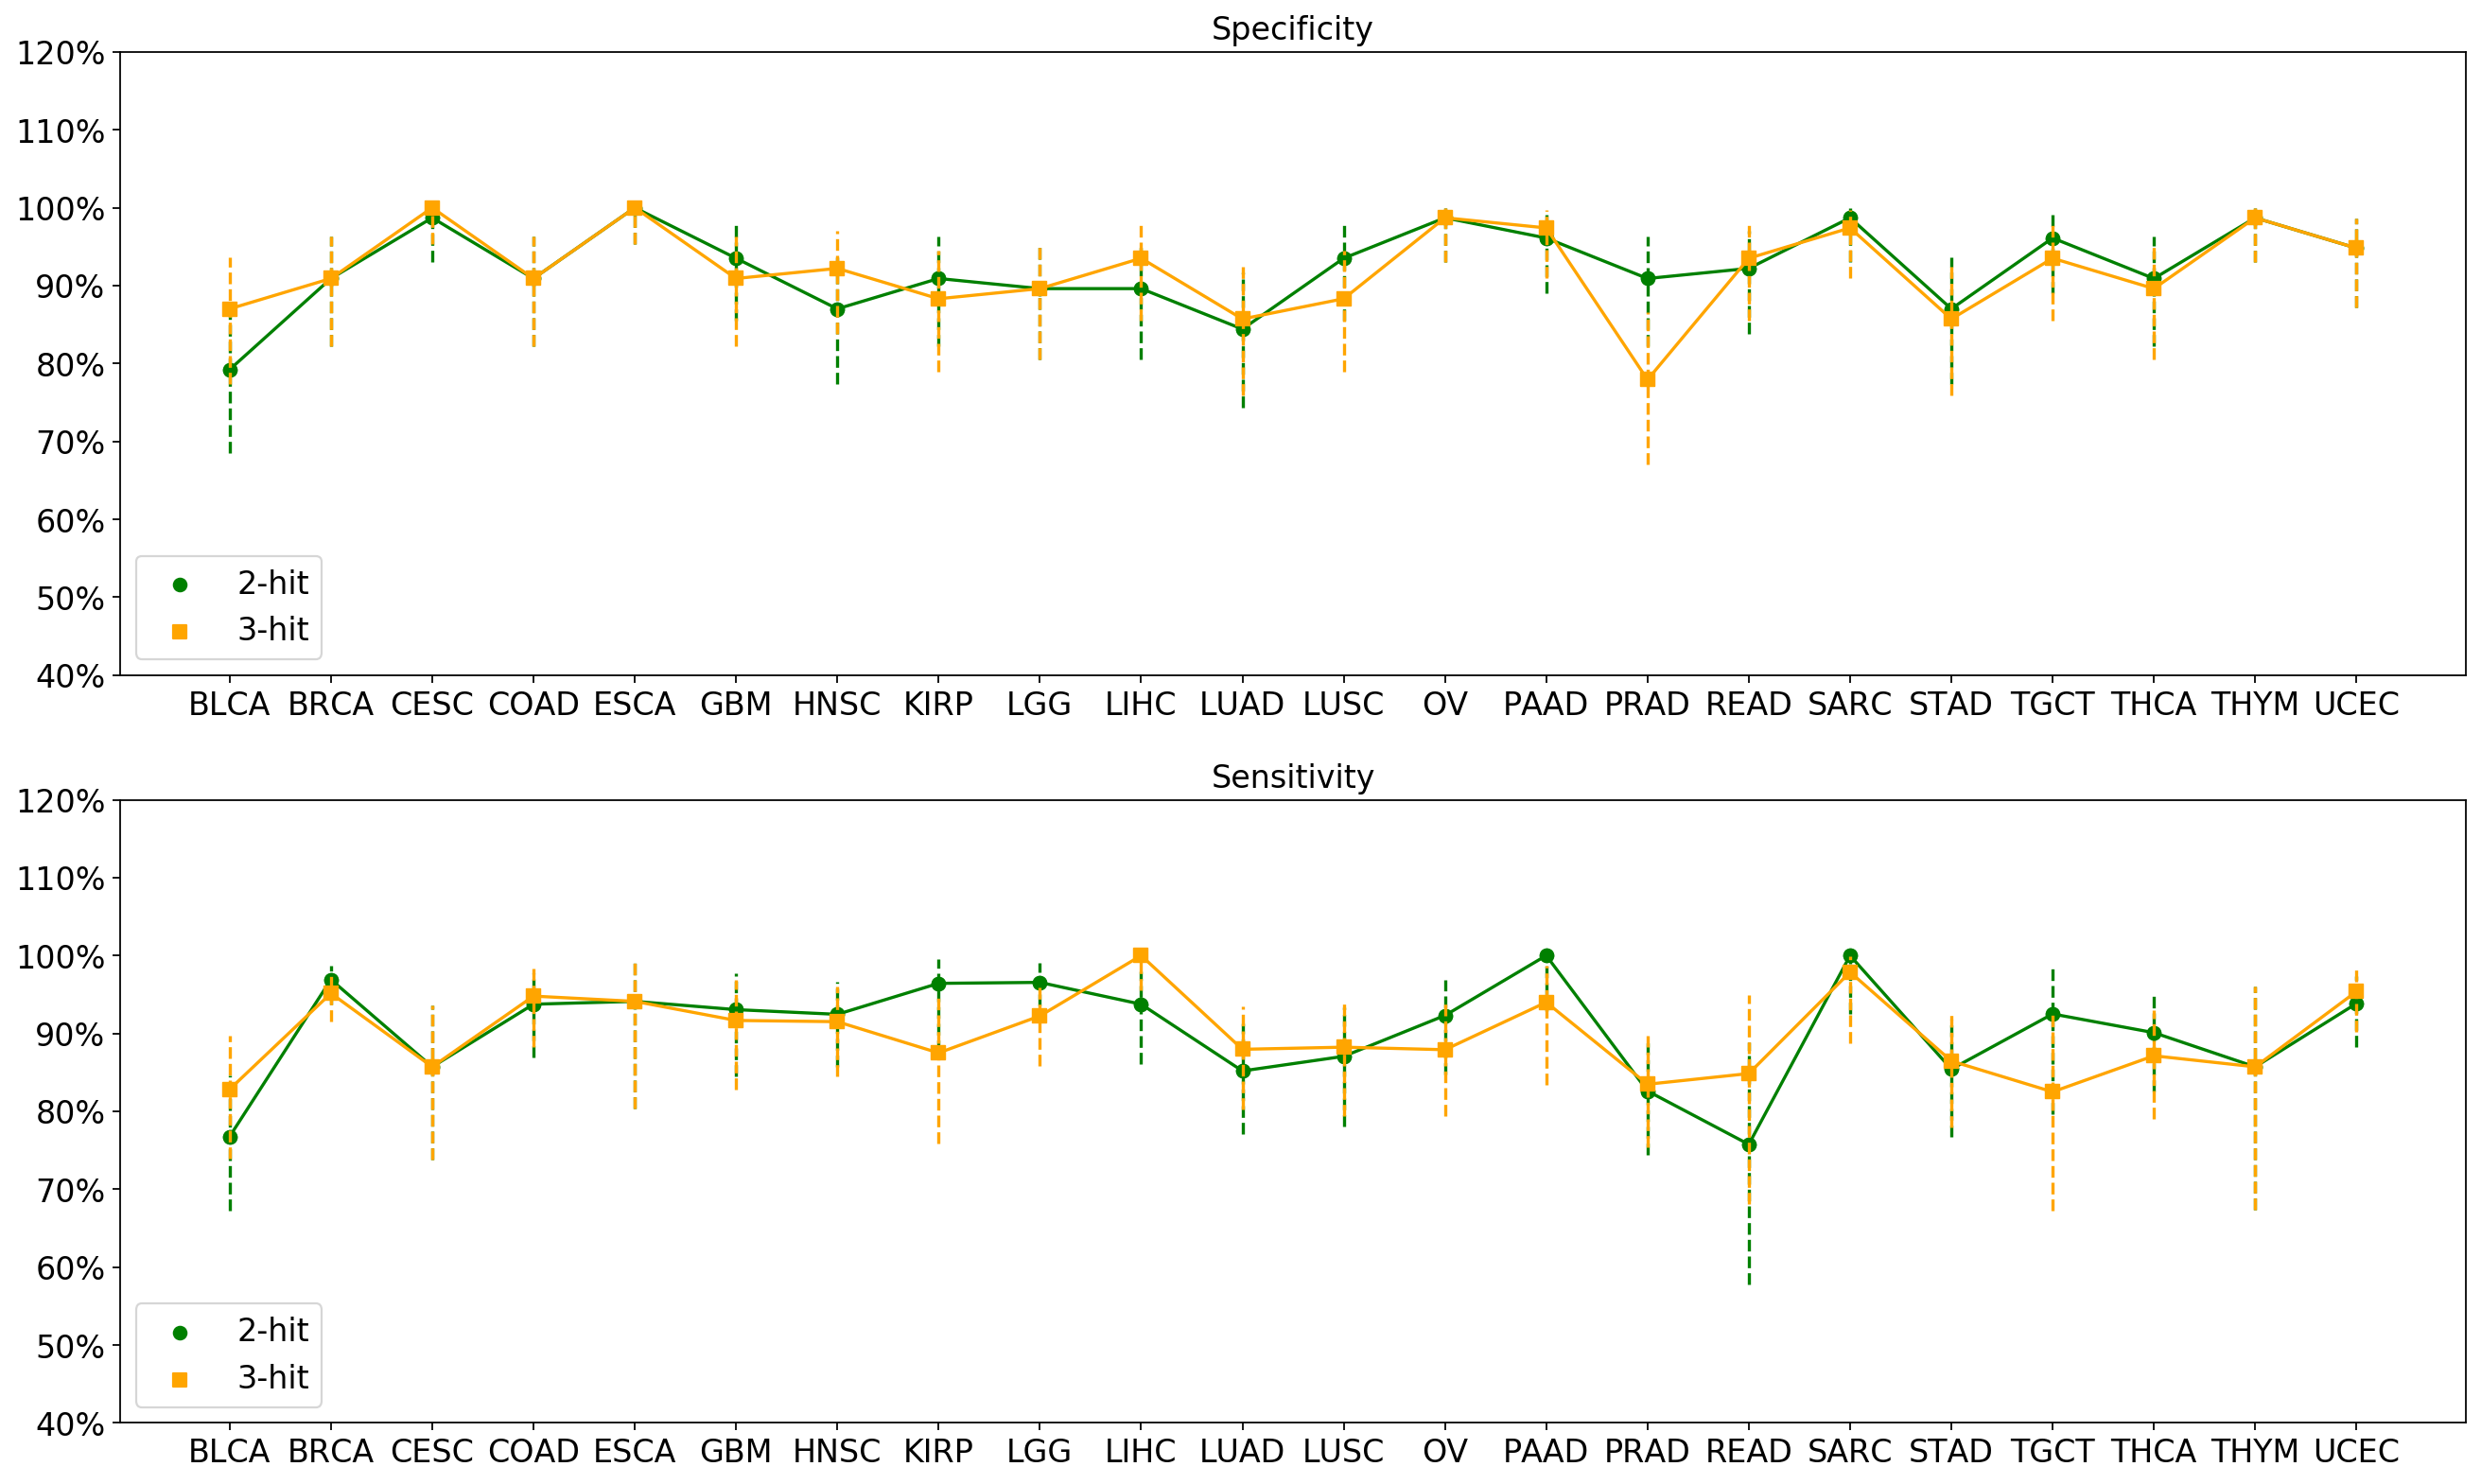

In [12]:
plot_performance(100, 12, 8, 15)

150 17
[0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2]


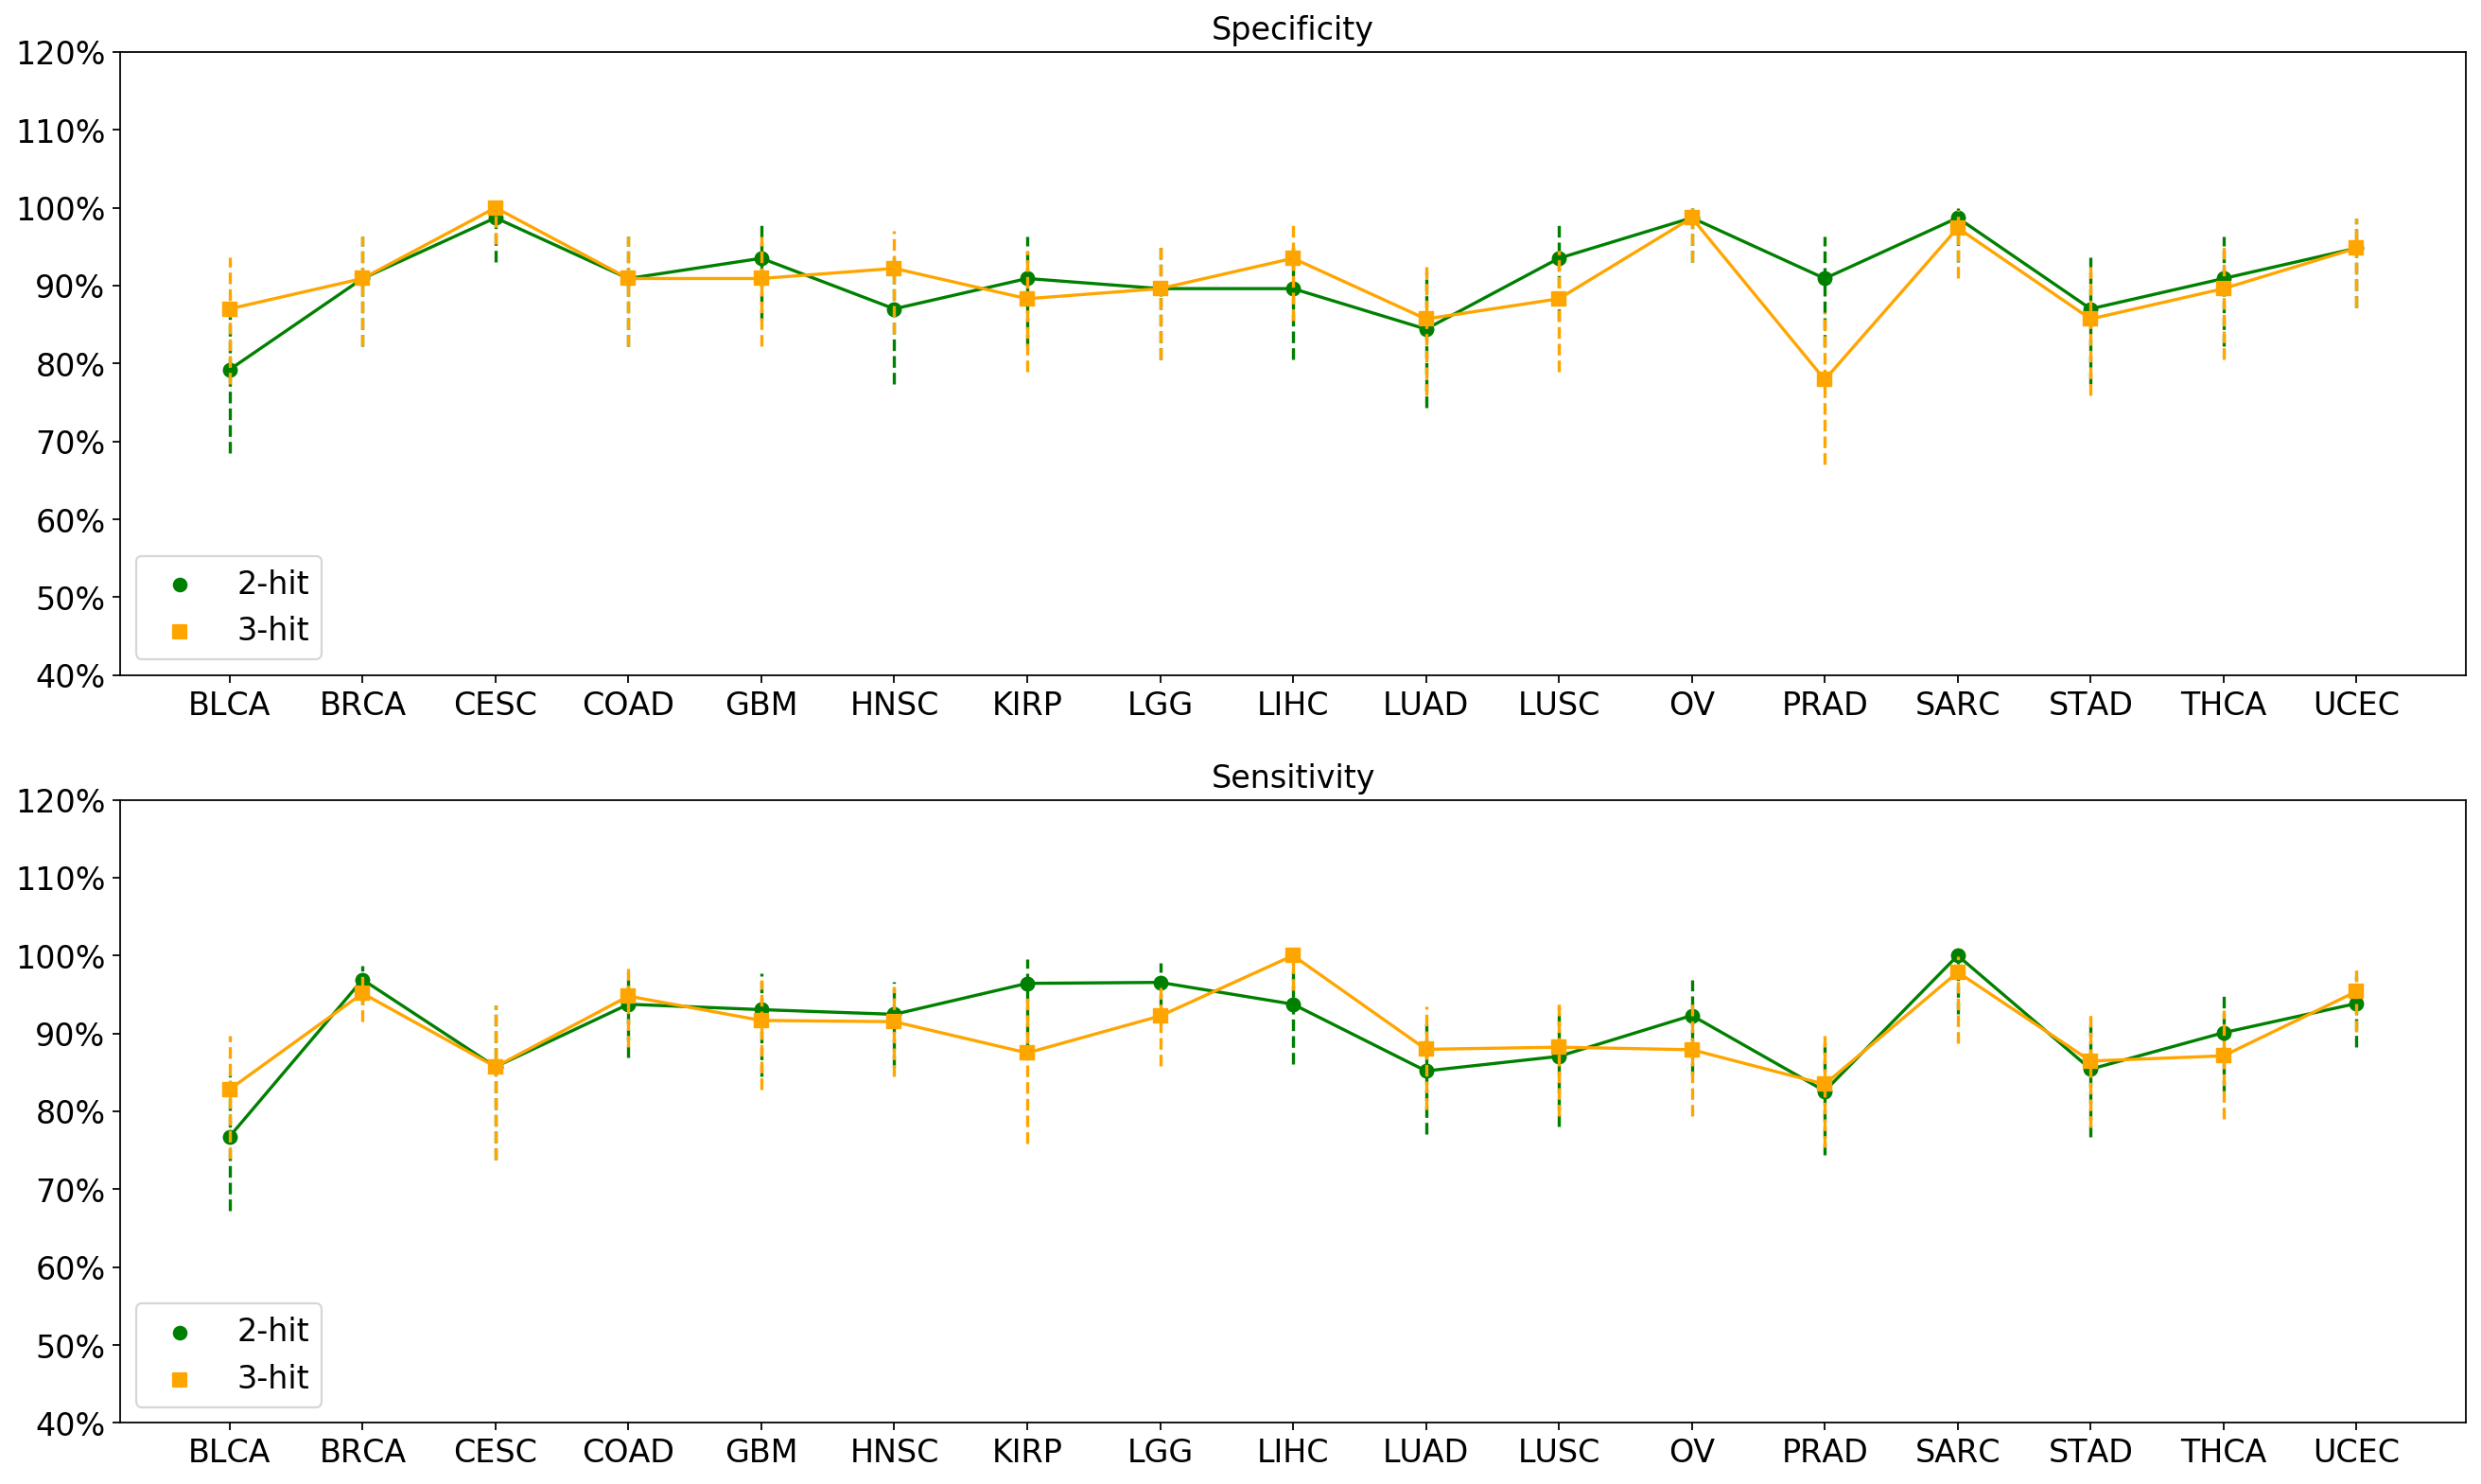

In [13]:
plot_performance(150, 12, 8, 15)

200 17
[0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2]


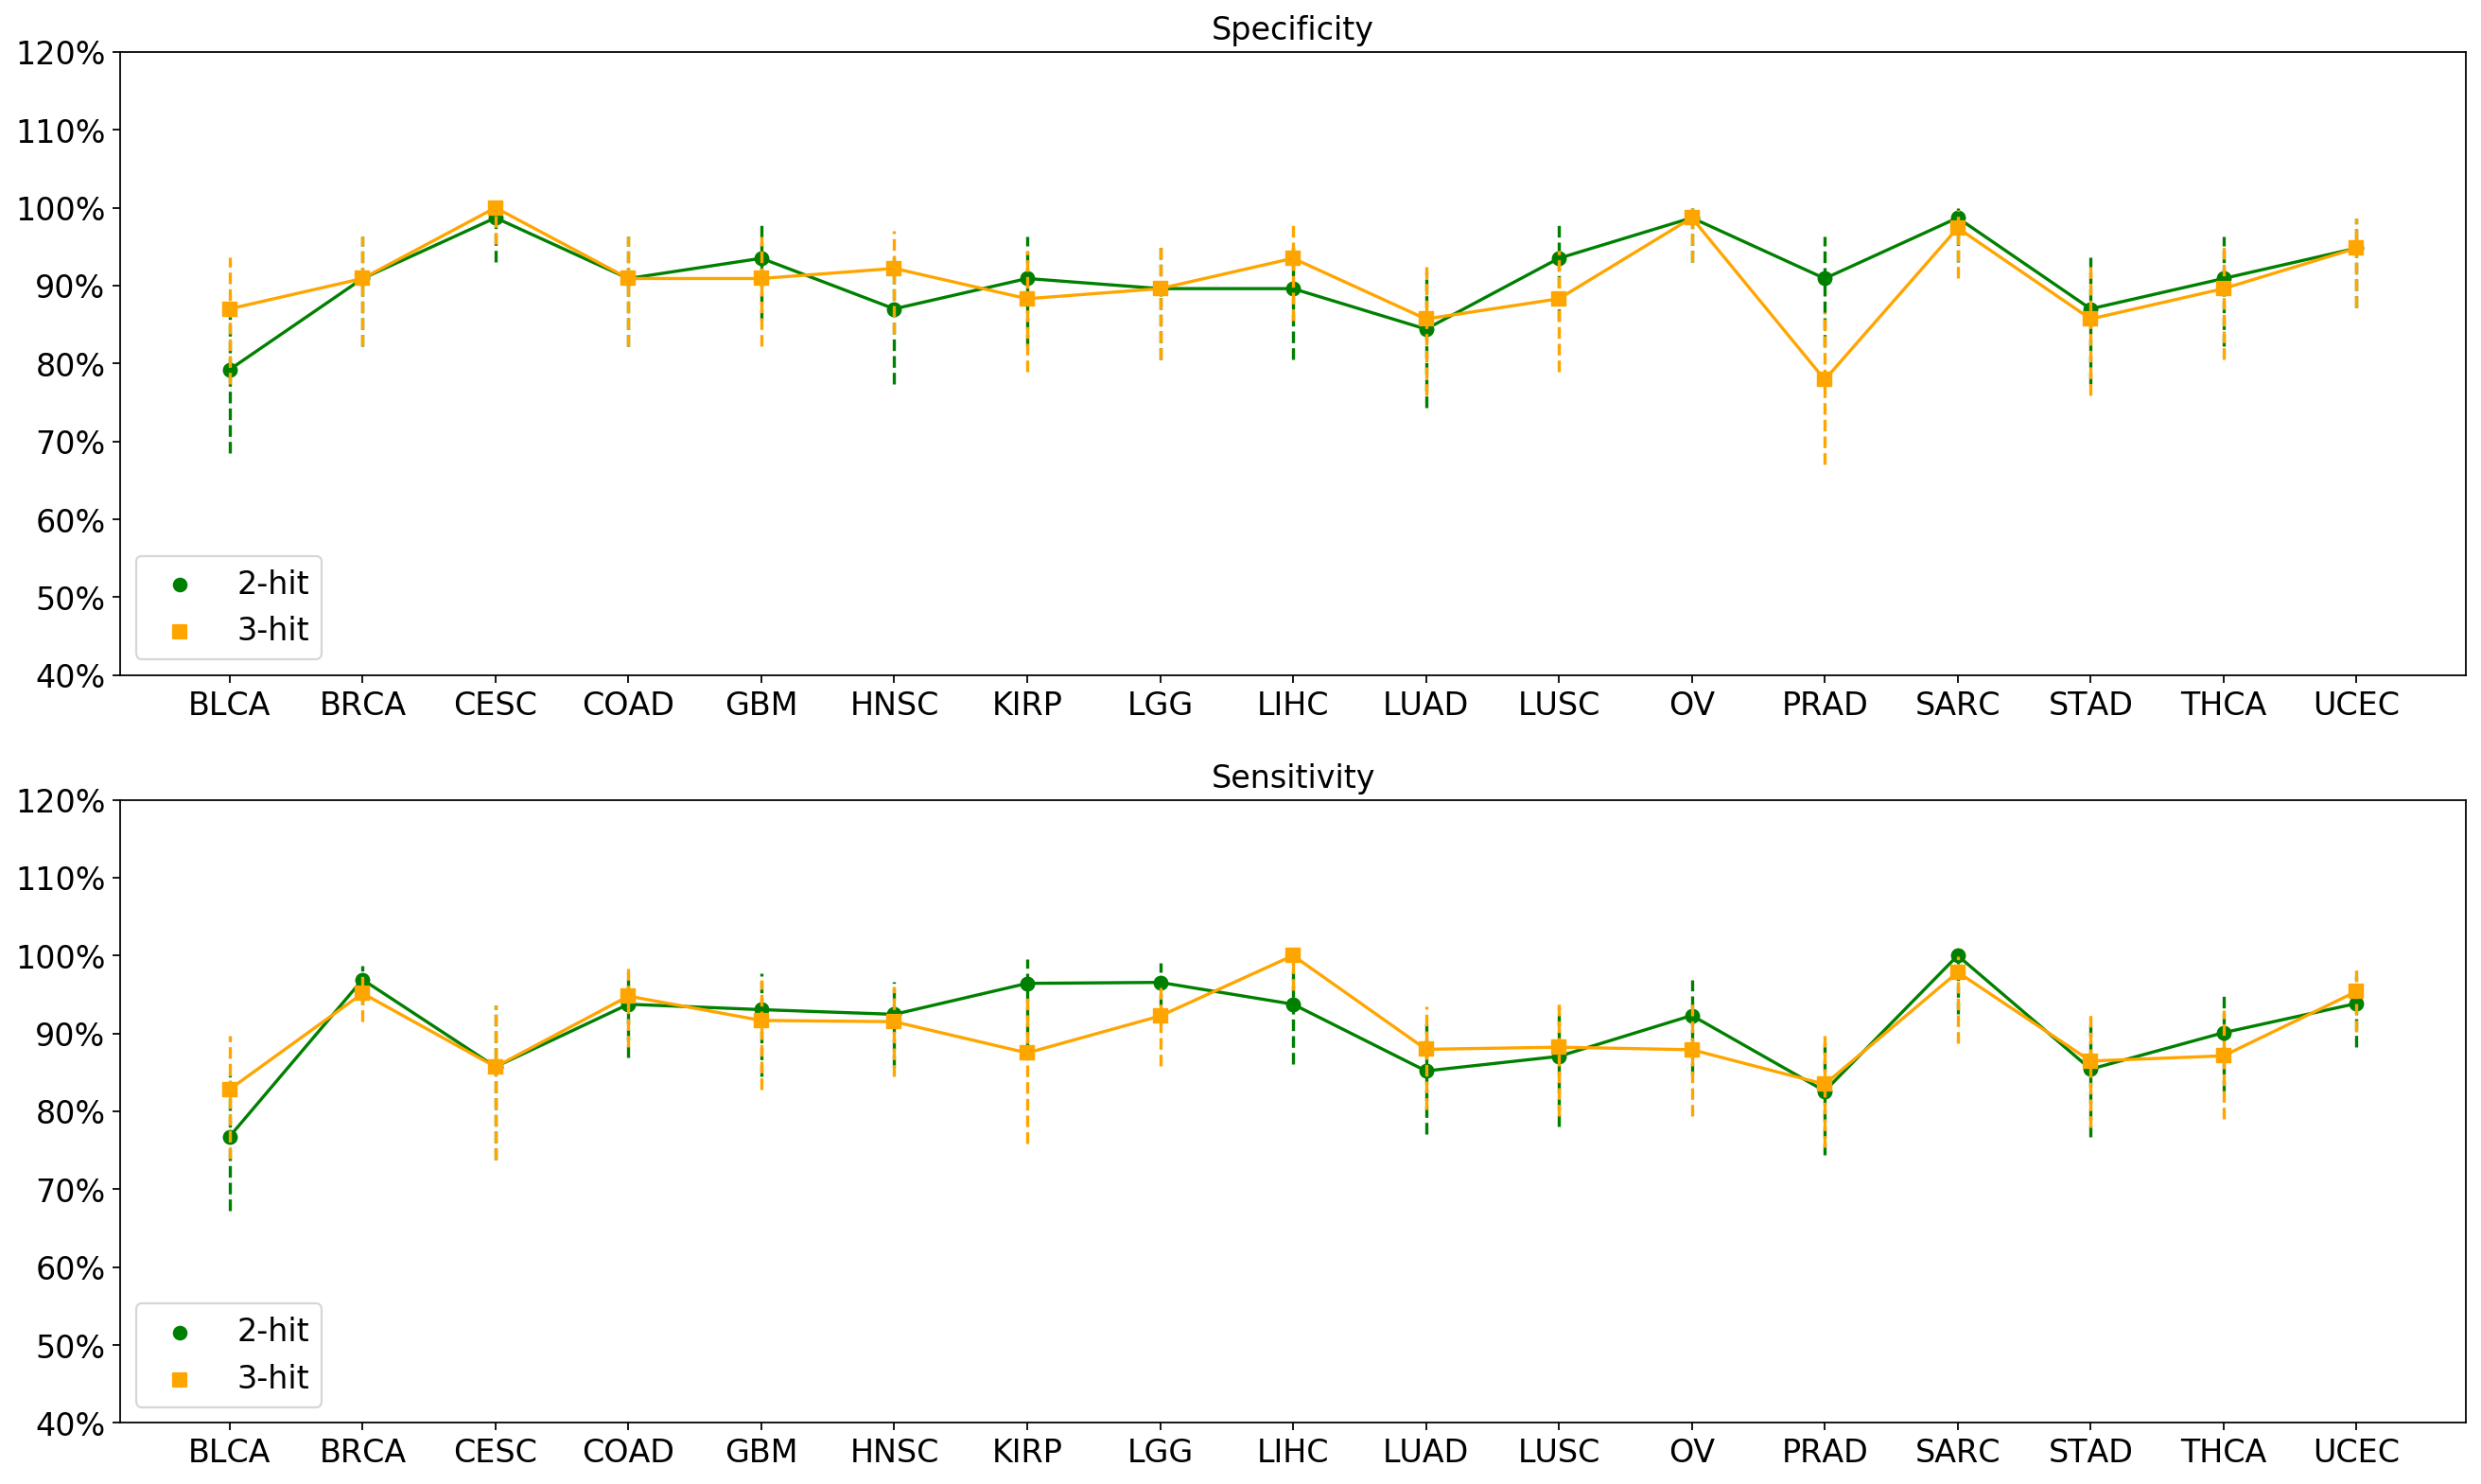

In [14]:
plot_performance(200, 12, 8, 15)

0 30
[0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2]


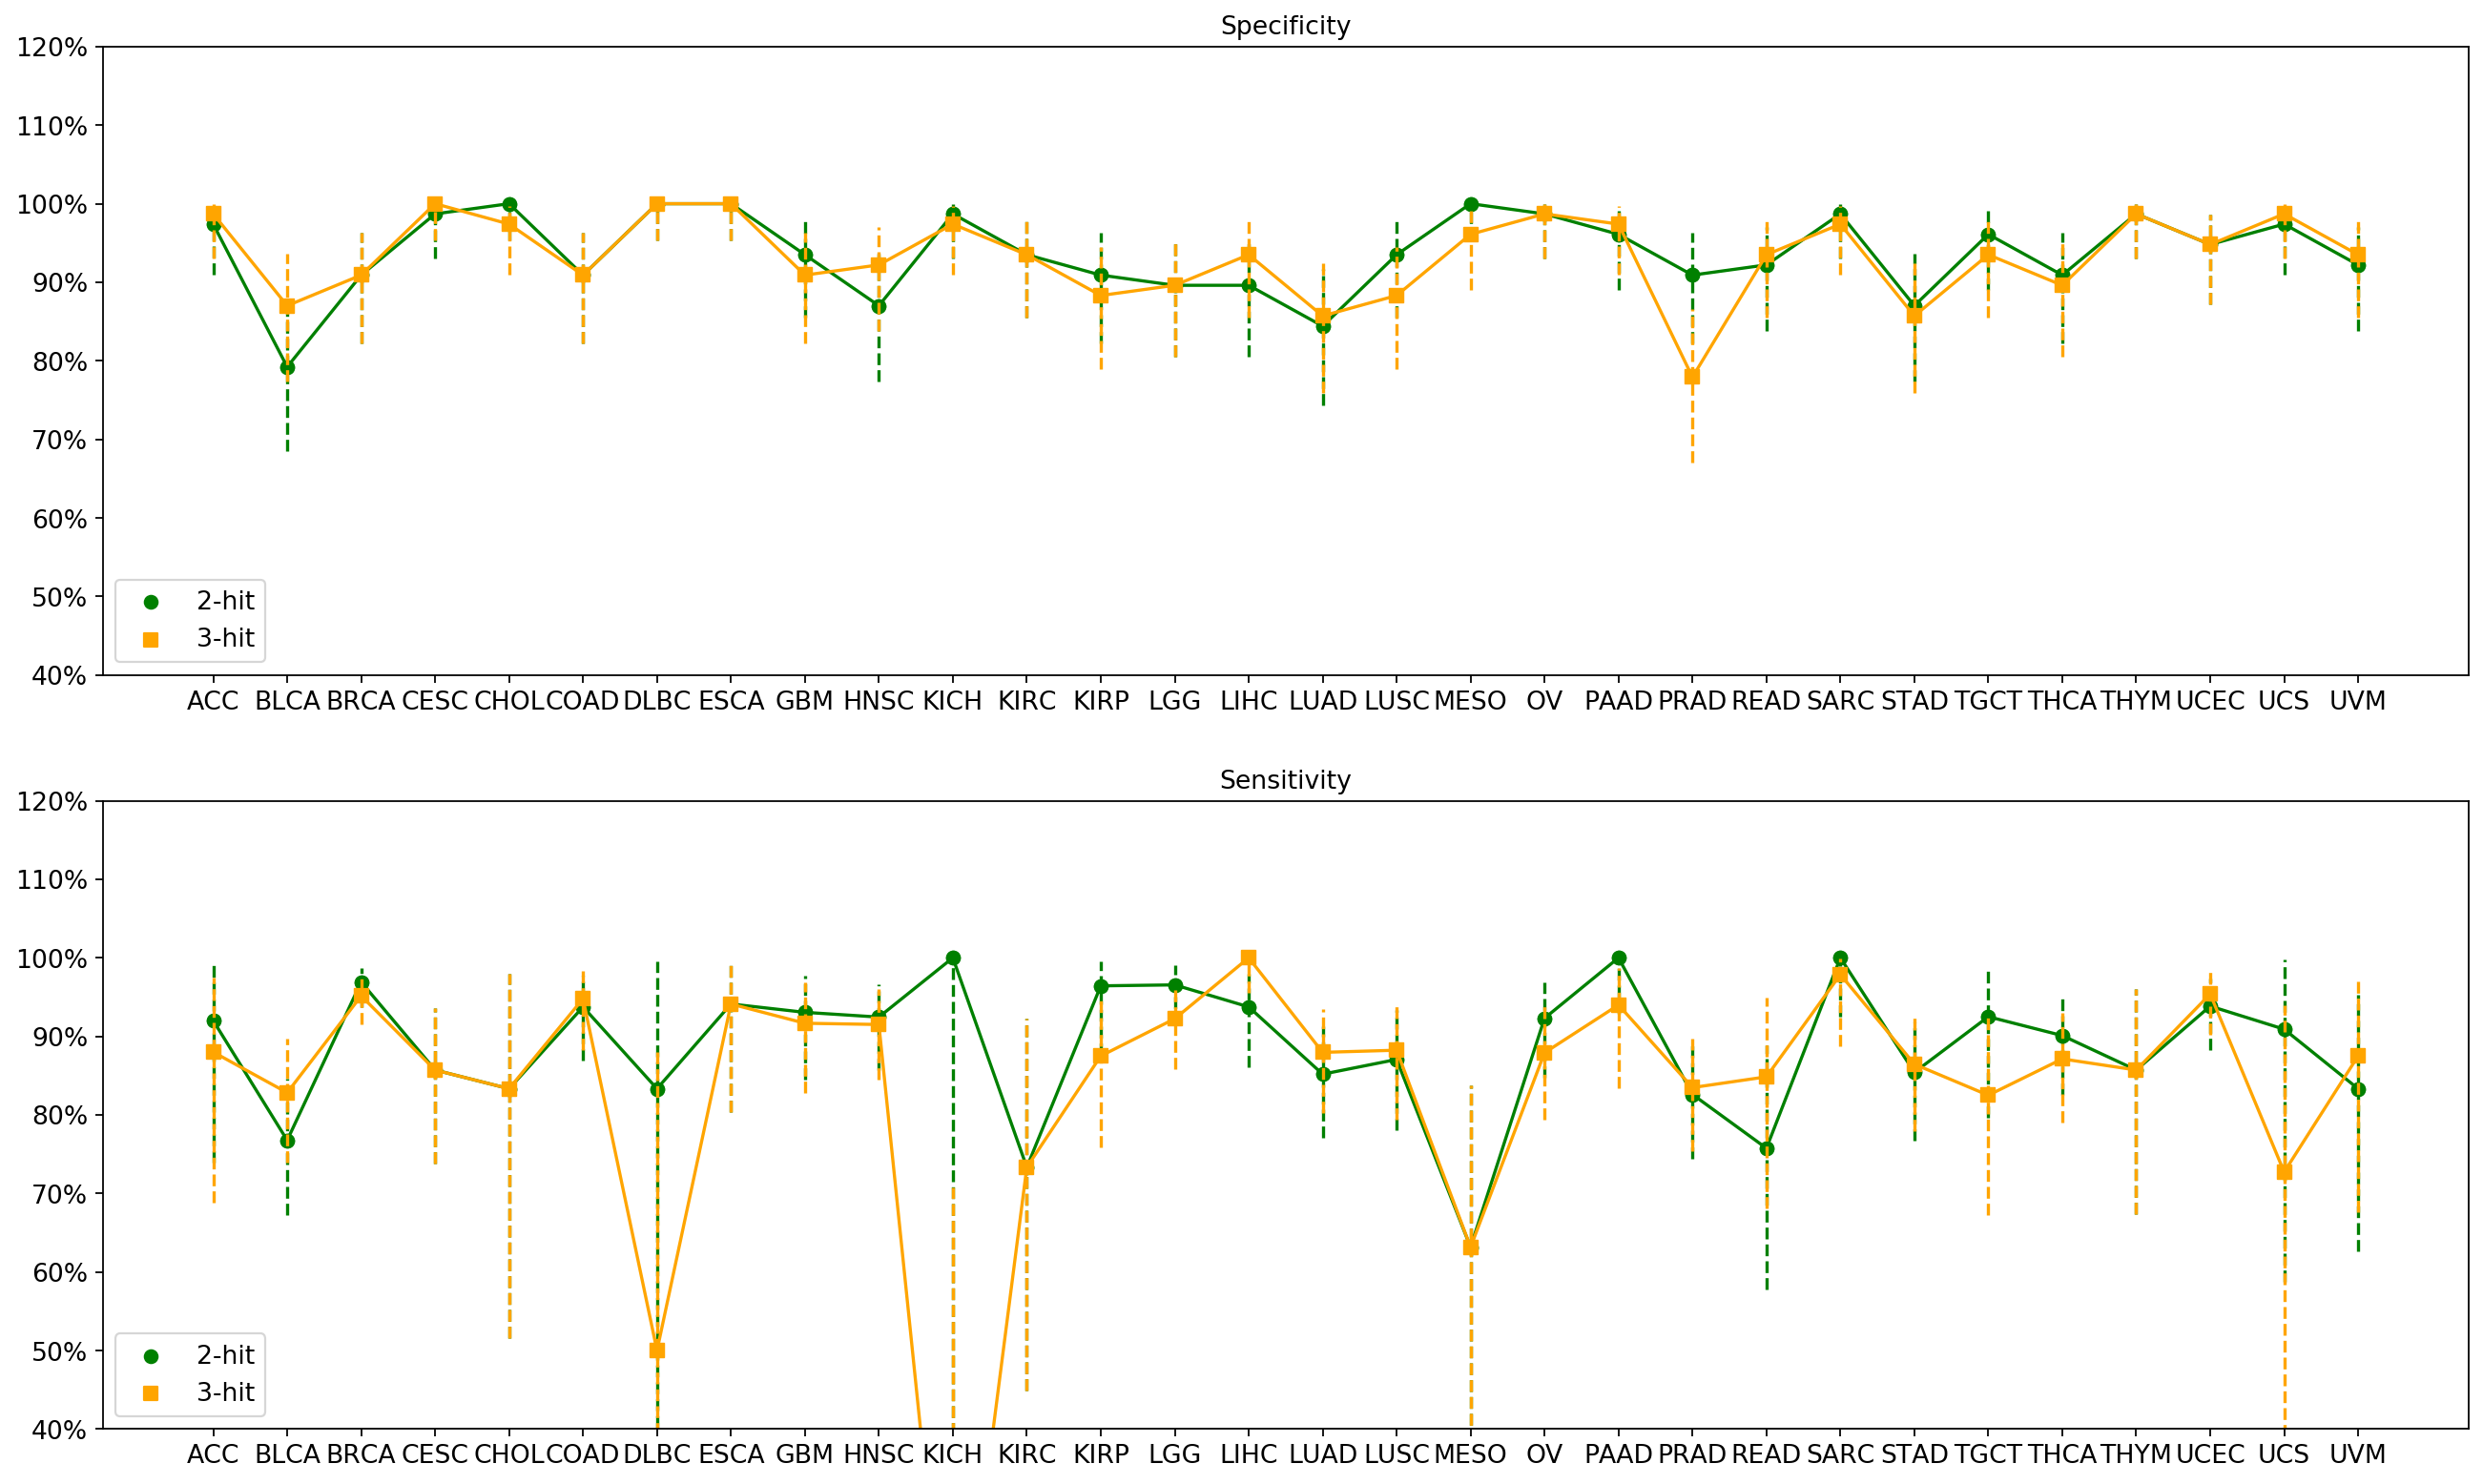

In [15]:
plot_performance(0, 20, 8, 12)

50 26
[0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2]


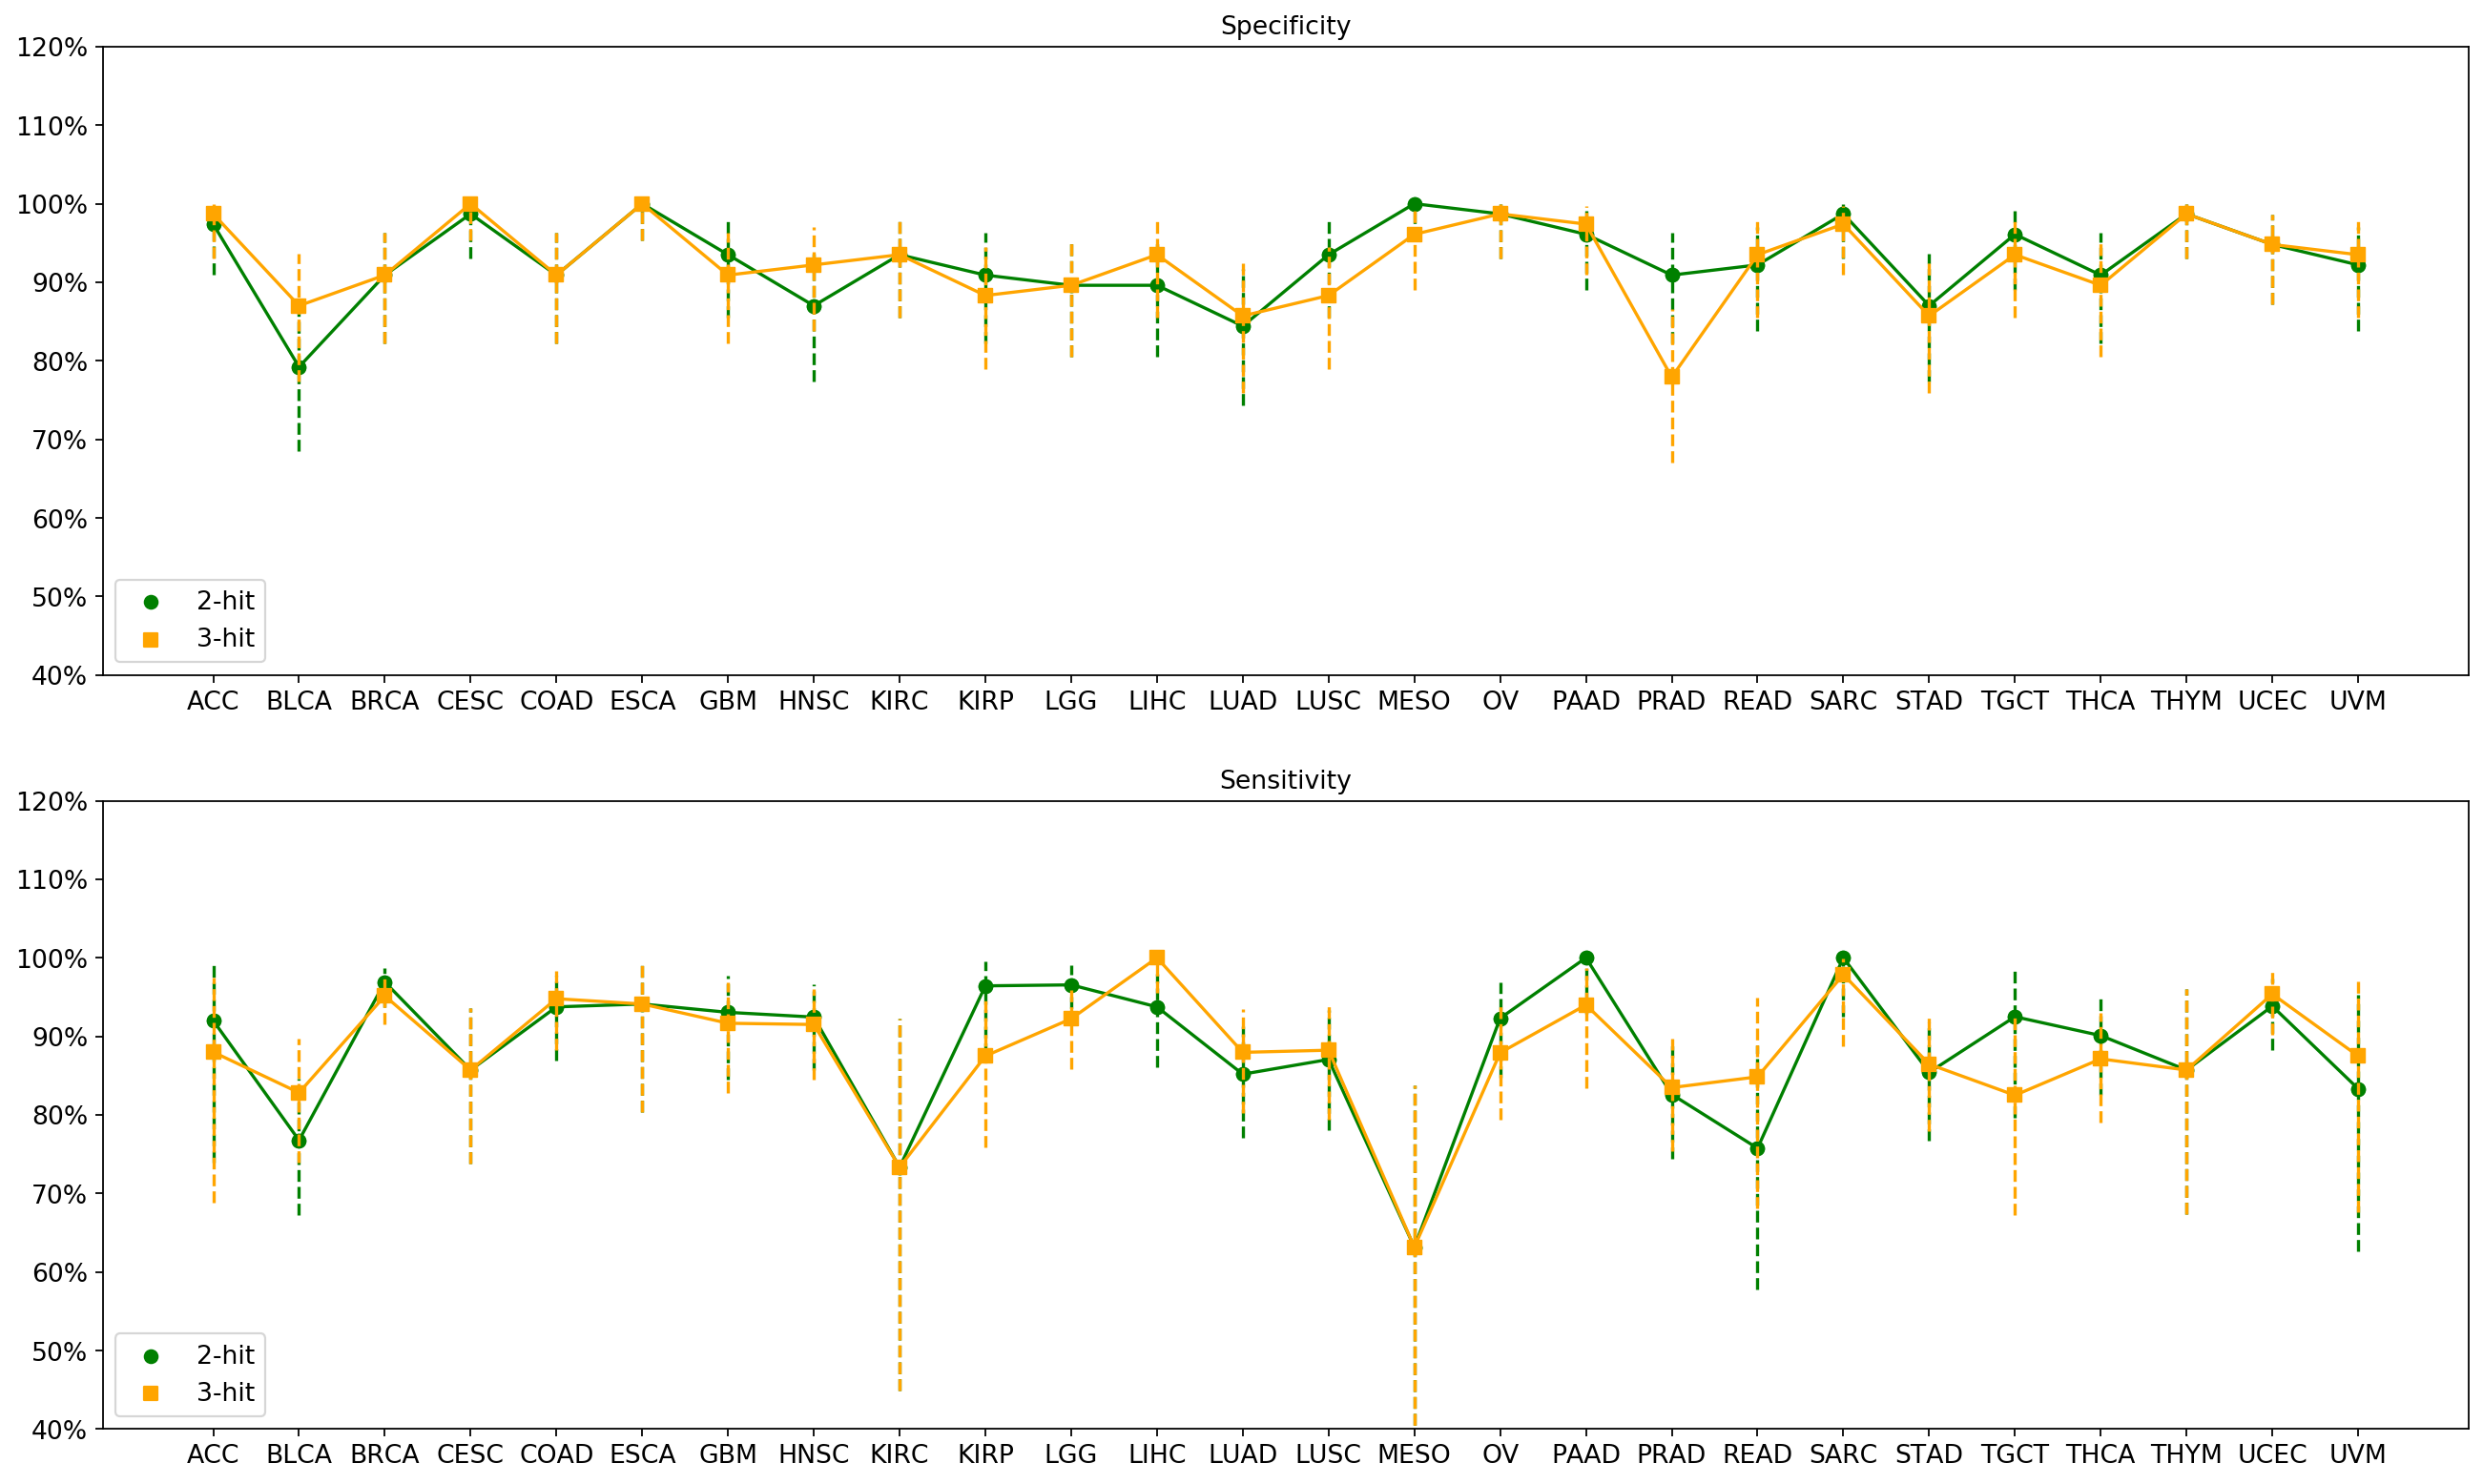

In [16]:
plot_performance(50, 20, 8, 12)

75 24
[0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2]


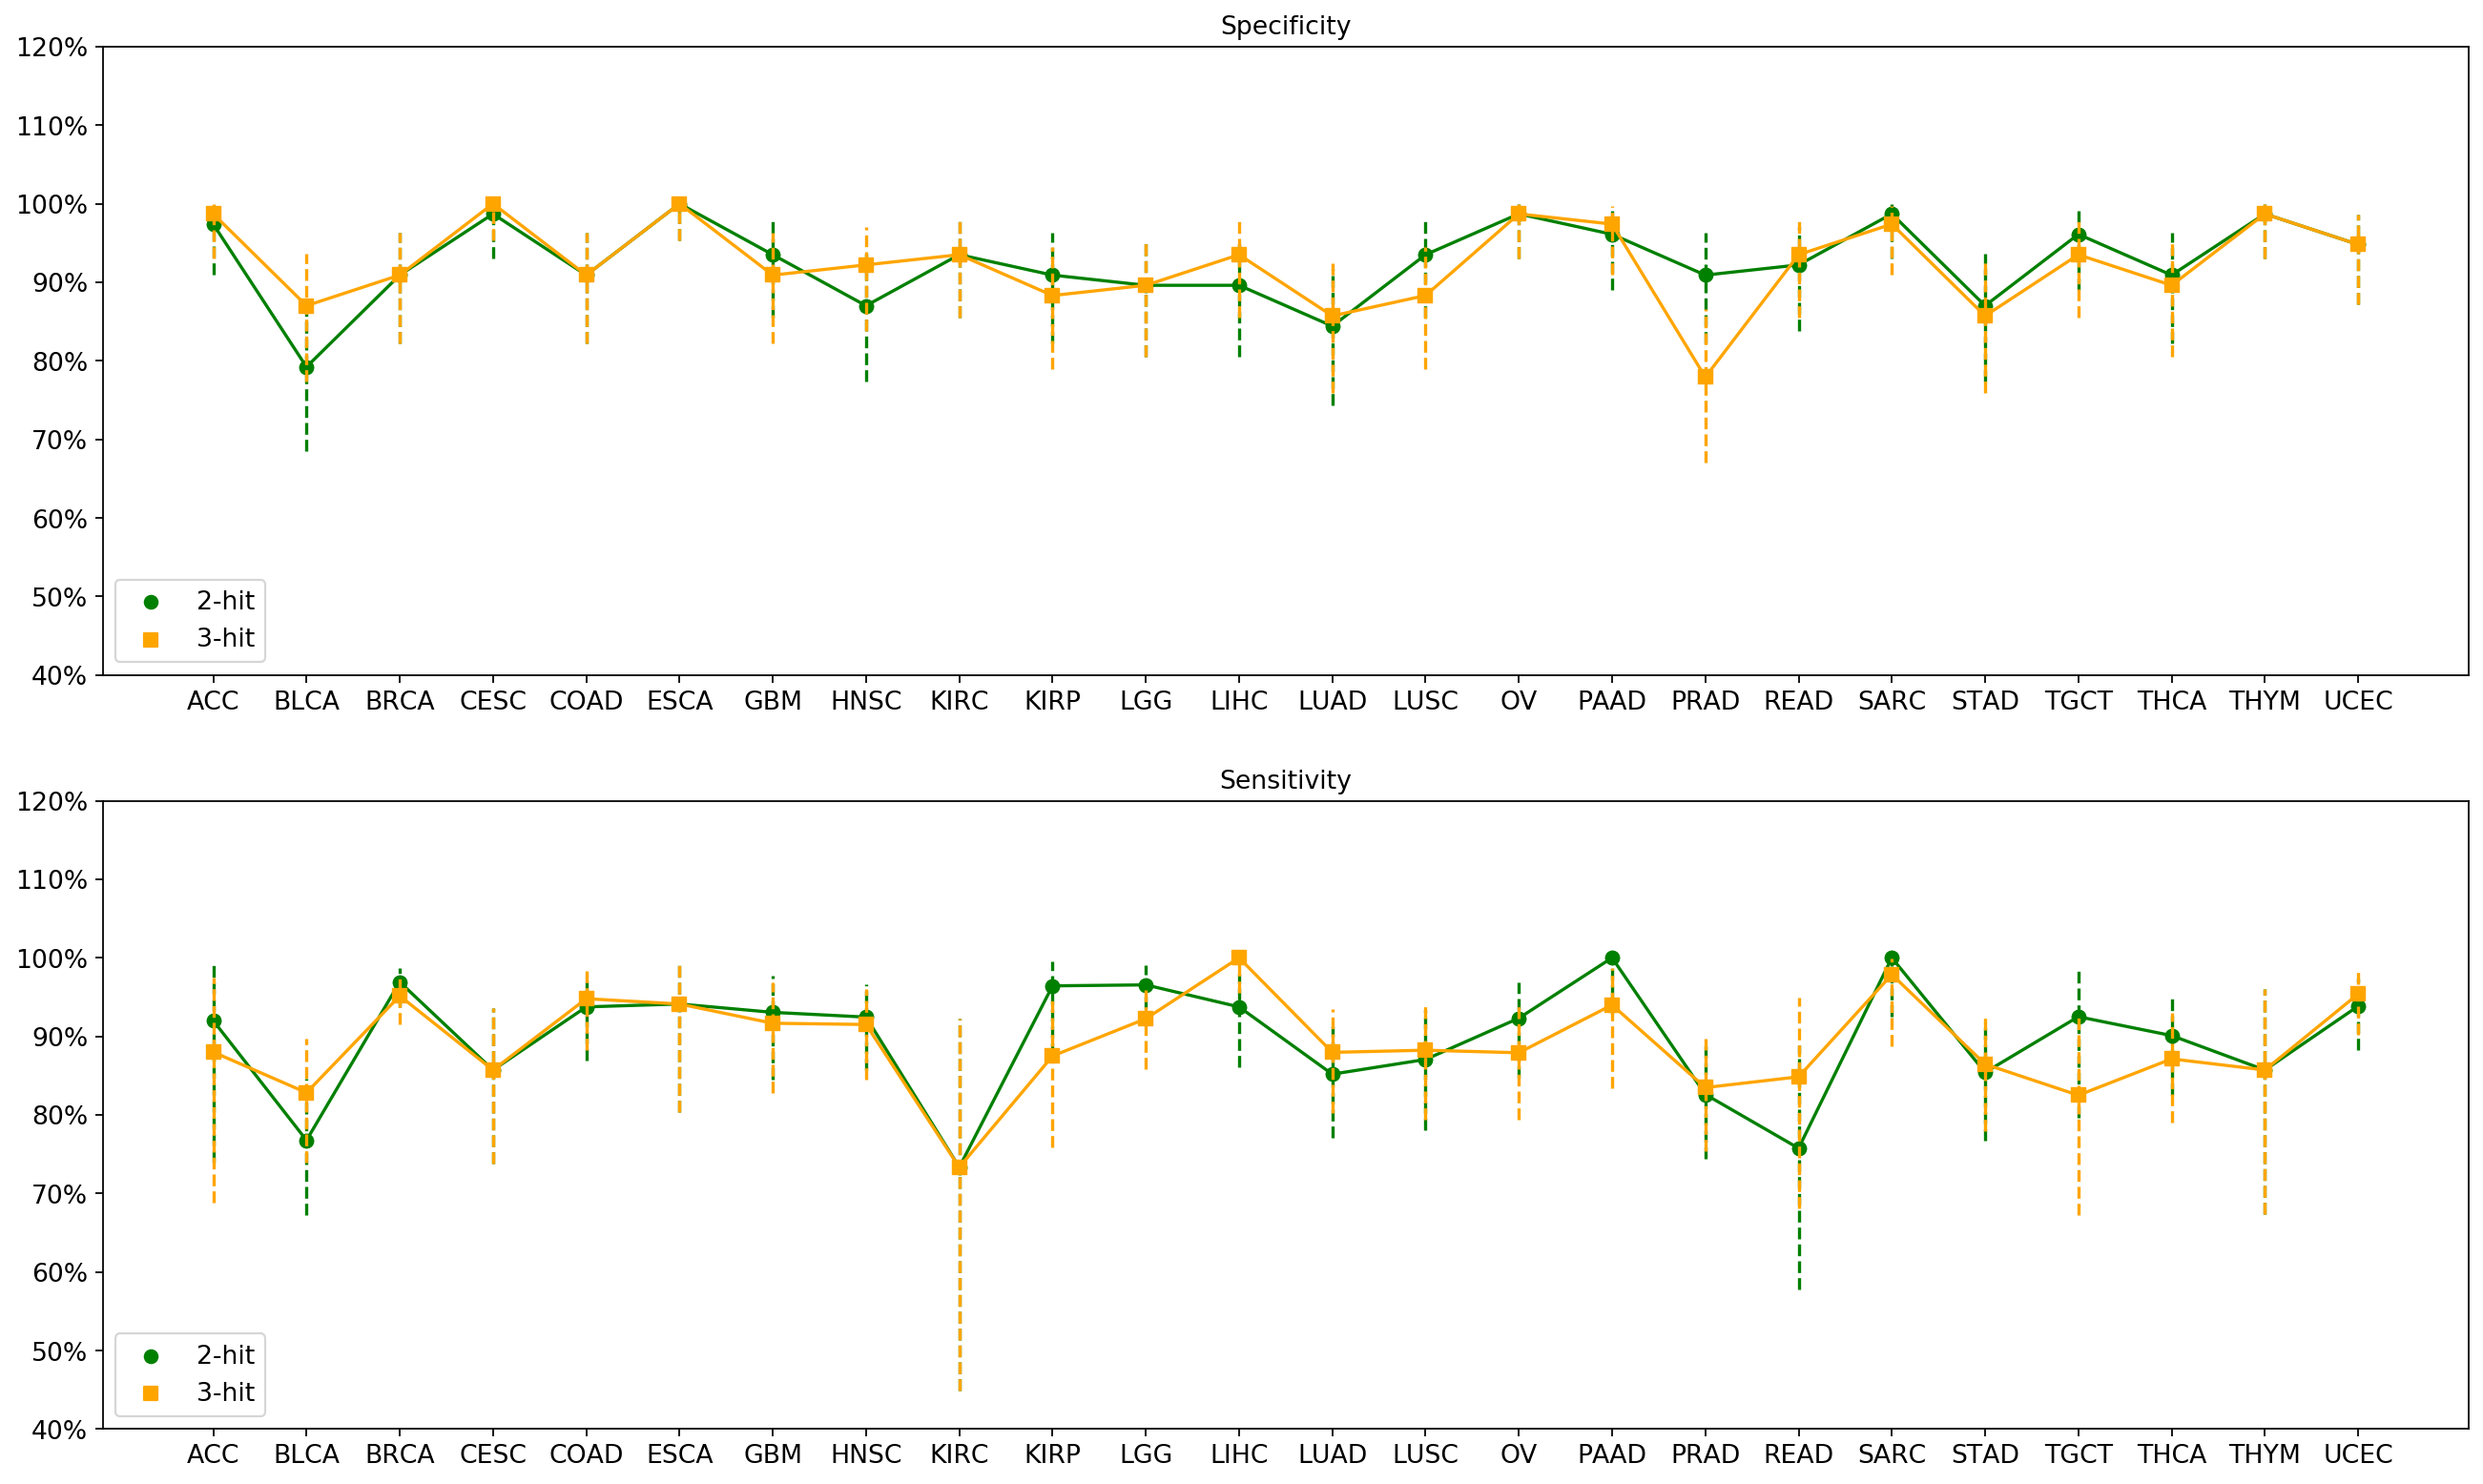

In [17]:
plot_performance(75, 20, 8, 12)

In [18]:
def write_all_stats():
    writer = open("../result/classification statistics 2hits.csv", "w")
    cancer_types = get_all_cancer_types()
    records_2hit = collect_all_performance("../data/2hit", cancer_types)
    headers = records_2hit["COAD"].keys()
    
    header = ",".join(headers)
    writer.write("Cancer," + header + "\n")
    for cancer in cancer_types:
        #print(cancer.upper())
        values = [str(item) for item in records_2hit[cancer].values()]
        writer.write(cancer.upper() + "," + ",".join(values) + "\n")
       
    writer.close()
    
    
    writer = open("../result/classification statistics 3hits.csv", "w")
    cancer_types = get_all_cancer_types()
    records_3hit = collect_all_performance("../data/3hit-gpu", cancer_types)
    headers = records_3hit["COAD"].keys()
    
    header = ",".join(headers)
    writer.write("Cancer," + header + "\n")
    for cancer in cancer_types:
        values = [str(item) for item in records_3hit[cancer].values()]
        writer.write(cancer.upper() + ","  + ",".join(values) + "\n")
    
   
    
write_all_stats() 

In [13]:
def get_num_combinations(directory):
    cancer_types = get_all_cancer_types()
    combination_counts = {}
    for cancer in cancer_types:
        with open(directory + "/" + cancer + "-combinations", "r") as reader:
            num_combs = 0
            for line in reader:
                if "excluded" in line:
                    num_combs += 1
            combination_counts[cancer] = num_combs
    return combination_counts
                    
print(get_num_combinations("../data/3hit-gpu"))

{'acc': 4, 'blca': 12, 'brca': 8, 'CESC': 9, 'CHOL': 3, 'COAD': 10, 'DLBC': 3, 'ESCA': 2, 'GBM': 10, 'HNSC': 12, 'KICH': 1, 'KIRC': 6, 'KIRP': 9, 'lgg': 11, 'LIHC': 8, 'LUAD': 10, 'LUSC': 10, 'MESO': 5, 'ov': 8, 'paad': 2, 'prad': 15, 'READ': 6, 'SARC': 6, 'STAD': 14, 'TGCT': 4, 'THCA': 13, 'thym': 3, 'UCEC': 9, 'UCS': 4, 'UVM': 5}


In [20]:
def create_result_table():
    cancer_types = get_all_cancer_types()
    records = collect_all_performance("../data/3hit-gpu", cancer_types)
    combination_counts = get_num_combinations("../data/3hit-gpu")
    x = "Training (Tumor Normal), Test (Tumor Normal)"
    print("Cancer Type & #Combinations & True Positives & False Negatives & Total & Sensitivity \
    & True Negatives & False Positives & Total & Specifcity &  True Positives & False Negatives\
    & Total & Sensitivity & 95% CI & True Negatives & False Positives & Total & Specifcity & 95% CI")
    
    #print("Cancer Type & #Combinations & True Positives & False Negatives & Total & Sensitivity & True Negatives & False Positives & Total & Specificity")
    for cancer in cancer_types:
        crecord = records[cancer]
        print(cancer.upper(), "&", combination_counts[cancer], "&",\
              crecord["train_tp"], "&", crecord["train_fn"], "&", crecord["train_tp"] + crecord["train_fn"], "&", "{:.0f}".format(100*crecord["train_sen"]) + "\%", \
              "&", crecord["train_tn"], "&", crecord["train_fp"], "&", crecord["train_tn"] + crecord["train_fp"], "&", "{:.0f}".format(100 * crecord["train_spec"]) + "\%", \
              "&", crecord["test_tp"], "&", crecord["test_fn"], "&", crecord["test_tp"] + crecord["test_fn"], "&", "{:.0f}".format(100 * crecord["test_sen"]) + "\%", "&", \
              "{:.0f}".format(100 * crecord["test_ci_sen"][0]) + "-" + "{:.0f}".format(100 * crecord["test_ci_sen"][1]) + "\%", \
              "&", crecord["test_tn"], "&", crecord["test_fp"], "&", crecord["test_tn"] + crecord["test_fp"], "&", "{:.0f}".format(100 * crecord["test_spec"]) + "\%", "&", \
              "{:.0f}".format(100 * crecord["test_ci_spec"][0]) + "-" + "{:.0f}".format(100 * crecord["test_ci_spec"][1]) + "\%",\
              "\\\\ \hline")
create_result_table()

Cancer Type & #Combinations & True Positives & False Negatives & Total & Sensitivity     & True Negatives & False Positives & Total & Specifcity &  True Positives & False Negatives    & Total & Sensitivity & 95% CI & True Negatives & False Positives & Total & Specifcity & 95% CI
ACC & 4 & 55 & 0 & 55 & 100\% & 256 & 0 & 256 & 100\% & 22 & 3 & 25 & 88\% & 69-97\% & 76 & 1 & 77 & 99\% & 93-100\% \\ \hline
BLCA & 12 & 269 & 0 & 269 & 100\% & 256 & 0 & 256 & 100\% & 82 & 17 & 99 & 83\% & 74-90\% & 67 & 10 & 77 & 87\% & 77-94\% \\ \hline
BRCA & 8 & 684 & 0 & 684 & 100\% & 248 & 8 & 256 & 97\% & 216 & 11 & 227 & 95\% & 91-98\% & 70 & 7 & 77 & 91\% & 82-96\% \\ \hline
CESC & 9 & 218 & 0 & 218 & 100\% & 256 & 0 & 256 & 100\% & 48 & 8 & 56 & 86\% & 74-94\% & 77 & 0 & 77 & 100\% & 95-100\% \\ \hline
CHOL & 3 & 32 & 0 & 32 & 100\% & 256 & 0 & 256 & 100\% & 10 & 2 & 12 & 83\% & 52-98\% & 75 & 2 & 77 & 97\% & 91-100\% \\ \hline
COAD & 10 & 289 & 0 & 289 & 100\% & 256 & 0 & 256 & 100\% & 91 & 5 & 96

In [14]:
combination_counts = get_num_combinations("../data/2hit")
cancer_types = get_all_cancer_types()
count = 0
for c in combination_counts:
    count += combination_counts[c]
print(count)
crecord = compute_aggregate_performance("../data/2hit", cancer_types)
print("Total", "&", count, "&",\
              crecord["train_tp"], "&", crecord["train_fn"], "&", crecord["train_tp"] + crecord["train_fn"], "&", "{:.0f}".format(100*crecord["train_sen"]) + "\%", \
              "&", crecord["train_tn"], "&", crecord["train_fp"], "&", crecord["train_tn"] + crecord["train_fp"], "&", "{:.0f}".format(100 * crecord["train_spec"]) + "\%", \
              "&", crecord["test_tp"], "&", crecord["test_fn"], "&", crecord["test_tp"] + crecord["test_fn"], "&", "{:.0f}".format(100 * crecord["test_sen"]) + "\%", "&", \
              "{:.0f}".format(100 * crecord["test_ci_sen"][0]) + "-" + "{:.0f}".format(100 * crecord["test_ci_sen"][1]) + "\%", \
              "&", crecord["test_tn"], "&", crecord["test_fp"], "&", crecord["test_tn"] + crecord["test_fp"], "&", "{:.0f}".format(100 * crecord["test_spec"]) + "\%", "&", \
              "{:.0f}".format(100 * crecord["test_ci_spec"][0]) + "-" + "{:.0f}".format(100 * crecord["test_ci_spec"][1]) + "\%",\
              "\\\\ \hline")

248
Total & 248 & 5862 & 0 & 5862 & 100\% & 7666 & 14 & 7680 & 100\% & 1789 & 192 & 1981 & 90\% & 89-92\% & 2165 & 145 & 2310 & 94\% & 93-95\% \\ \hline


In [15]:
def create_result_table_csv():
    cancer_types = get_all_cancer_types()
    records = collect_all_performance("../data/2hit", cancer_types)
    combination_counts = get_num_combinations("../data/2hit")
    x = "Training (Tumor Normal), Test (Tumor Normal)"
    
    print("Cancer Type,#Combinations,True Positives,False Negatives,Total,Sensitivity\
    ,True Negatives,False Positives,Total,Specifcity,True Positives,False Negatives,\
    Total,Sensitivity,95% CI,True Negatives,False Positives,Total,Specifcity,95% CI")
    
    #print("Cancer Type & #Combinations & True Positives & False Negatives & Total & Sensitivity & True Negatives & False Positives & Total & Specificity")
    for cancer in cancer_types:
        crecord = records[cancer]
        print(cancer.upper(), ",", combination_counts[cancer], ",",\
              crecord["train_tp"], ",", crecord["train_fn"], ",", crecord["train_tp"] + crecord["train_fn"], ",", "{:.0f}".format(100*crecord["train_sen"]) + "%", \
              ",", crecord["train_tn"], ",", crecord["train_fp"], ",", crecord["train_tn"] + crecord["train_fp"], ",", "{:.0f}".format(100 * crecord["train_spec"]) + "%", \
              ",", crecord["test_tp"], ",", crecord["test_fn"], ",", crecord["test_tp"] + crecord["test_fn"], ",", "{:.0f}".format(100 * crecord["test_sen"]) + "%", ",", \
              "{:.0f}".format(100 * crecord["test_ci_sen"][0]) + "-" + "{:.0f}".format(100 * crecord["test_ci_sen"][1]) + "%", \
              ",", crecord["test_tn"], ",", crecord["test_fp"], ",", crecord["test_tn"] + crecord["test_fp"], ",", "{:.0f}".format(100 * crecord["test_spec"]) + "%", ",", \
              "{:.0f}".format(100 * crecord["test_ci_spec"][0]) + "-" + "{:.0f}".format(100 * crecord["test_ci_spec"][1]) + "%"
             )
        
    
    count = 0
    for c in combination_counts:
        count += combination_counts[c]
        
    crecord = compute_aggregate_performance("../data/2hit", cancer_types)
    print("Total", ",", count, ",",\
              crecord["train_tp"], ",", crecord["train_fn"], ",", crecord["train_tp"] + crecord["train_fn"], ",", "{:.0f}".format(100*crecord["train_sen"]) + "%", \
              ",", crecord["train_tn"], ",", crecord["train_fp"], ",", crecord["train_tn"] + crecord["train_fp"], ",", "{:.0f}".format(100 * crecord["train_spec"]) + "%", \
              ",", crecord["test_tp"], ",", crecord["test_fn"], ",", crecord["test_tp"] + crecord["test_fn"], ",", "{:.0f}".format(100 * crecord["test_sen"]) + "%", ",", \
              "{:.0f}".format(100 * crecord["test_ci_sen"][0]) + "-" + "{:.0f}".format(100 * crecord["test_ci_sen"][1]) + "%", \
              ",", crecord["test_tn"], ",", crecord["test_fp"], ",", crecord["test_tn"] + crecord["test_fp"], "&", "{:.0f}".format(100 * crecord["test_spec"]) + "%", ",", \
              "{:.0f}".format(100 * crecord["test_ci_spec"][0]) + "-" + "{:.0f}".format(100 * crecord["test_ci_spec"][1]) + "%"
              )
create_result_table_csv()

Cancer Type,#Combinations,True Positives,False Negatives,Total,Sensitivity    ,True Negatives,False Positives,Total,Specifcity,True Positives,False Negatives,    Total,Sensitivity,95% CI,True Negatives,False Positives,Total,Specifcity,95% CI
ACC , 5 , 55 , 0 , 55 , 100% , 256 , 0 , 256 , 100% , 23 , 2 , 25 , 92% , 74-99% , 75 , 2 , 77 , 97% , 91-100%
BLCA , 15 , 269 , 0 , 269 , 100% , 256 , 0 , 256 , 100% , 76 , 23 , 99 , 77% , 67-85% , 61 , 16 , 77 , 79% , 68-88%
BRCA , 8 , 684 , 0 , 684 , 100% , 248 , 8 , 256 , 97% , 220 , 7 , 227 , 97% , 94-99% , 70 , 7 , 77 , 91% , 82-96%
CESC , 8 , 218 , 0 , 218 , 100% , 256 , 0 , 256 , 100% , 48 , 8 , 56 , 86% , 74-94% , 76 , 1 , 77 , 99% , 93-100%
CHOL , 3 , 32 , 0 , 32 , 100% , 256 , 0 , 256 , 100% , 10 , 2 , 12 , 83% , 52-98% , 77 , 0 , 77 , 100% , 95-100%
COAD , 10 , 289 , 0 , 289 , 100% , 256 , 0 , 256 , 100% , 90 , 6 , 96 , 94% , 87-98% , 70 , 7 , 77 , 91% , 82-96%
DLBC , 3 , 37 , 0 , 37 , 100% , 256 , 0 , 256 , 100% , 5 , 1 , 6 , 83% , 36-